In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner
import pandas as pd
from project.Urbano08.Optimizer import Optimizer

# EXPLORATION PHASE

In [2]:
n_obs = 100
n_obs_exploration = round(n_obs*2/3)
n_obs_exploitation = n_obs-n_obs_exploration
n_subcamp = 3
max_bid = 1
max_clicks = 100
n_arms = 11

bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])

noise_std = 6.0
env = BiddingEnvironment(bids,max_clicks,noise_std)

learners = []
for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
# BISOGNA USARE IL DATAFRAME DI PANDA AL POSTO DEGLI X_OBS E Y_OBS  (PER ORA SONO DATI RIPETUTI)
for i in range(0, n_obs_exploration):
    clicks = []

    #Pull an arm for each sub-campaign:
    #It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
    #For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
    ### N.B. This behaviour works only for arms linearly distributed  over the array_bids
    first = i % 3
    pulled = [0,0,0]
    pulled[first] = learners[first].pull_arm()
    pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
    pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)


11
11
11


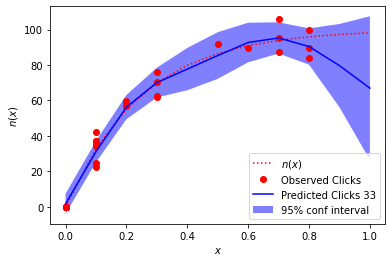

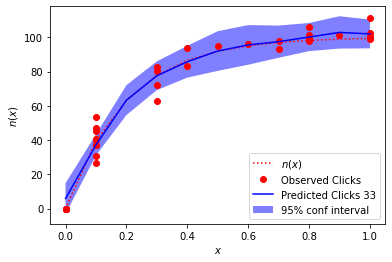

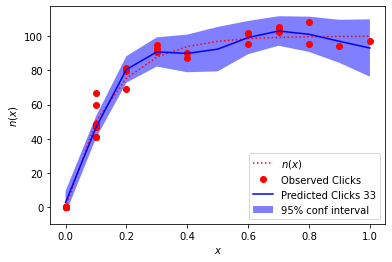

In [4]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])

# EXPLOITATION PHASE


In [5]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)
print(Optimizer.fit_table(table_all_Subs))



[[  1.68626567  31.15204693  56.23418344  70.09375513  77.68768998
   85.3392137   92.69968845  95.27154599  90.43026888  79.66009953
   66.9675219 ]
 [  5.85709054  37.18158174  63.28655998  77.52933781  85.70604429
   91.94204714  95.53351317  97.41232124 100.10660227 102.82423381
  101.94568964]
 [  2.82775436  46.72651358  80.53713583  90.76204736  89.88947814
   92.39211674  99.12897745 102.98985063 101.06582016  96.96405374
   93.03608711]]
([3, 4, 3], 246.56184677514509)


In [6]:
for i in range(0, n_obs_exploitation):
    clicks = []

    # for l in learners:
    #     table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

    #Pull an arm for each sub-campaign:
    #It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
    #For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
    ### N.B. This behaviour works only for arms linearly distributed  over the array_bids
    pulled = [0,0,0]
    pulled[0] = Optimizer.fit_table(table_all_Subs)[0][0]
    pulled[1] = Optimizer.fit_table(table_all_Subs)[0][1]
    pulled[2] = Optimizer.fit_table(table_all_Subs)[0][2]

    print("\n------------")
    print(pulled[0])
    print(pulled[1])
    print(pulled[2])
    print("------------\n")


    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for l in learners:
        table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
5
3
2
------------


------------
4
3
3
------------


------------
5
2
3
------------


------------
4
4
2
------------


------------
4
4
2
------------


------------
3
4
3
------------


------------
3
4
3
------------


------------
5
3
2
------------


------------
4
3
3
------------



## Optimization algorithm
Now we solve the optimization problem as a special case of Multiple-Choice Knapsack problem (Sinha and Zoltners 1979),
Here we use the samples returned by the bandit algorithms.

In [7]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)


[[  2.12213311  30.45781538  55.34832356  70.73822567  79.9385606
   87.58553858  93.61334707  95.11768091  90.79291847  82.30023931
   72.73099731]
 [  8.47540839  35.6170883   61.31216639  78.93936051  88.01352857
   92.01421494  94.58696959  97.45107638 100.431564   102.36064767
  102.02212058]
 [  2.9612072   46.57649241  78.34073624  87.39891863  88.39503234
   92.87071169  99.61475706 102.94959372 100.96093719  97.00949642
   93.65368063]]


In [8]:
algorithm_table = np.ndarray(shape=(0,len(bids)), dtype=float)

for l in learners:
   algorithm_table = np.append(algorithm_table,np.atleast_2d(np.zeros(len(bids))),0)

algorithm_table[0,:] = table_all_Subs[0,:]

allocations_table = [[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]]


for i in range(1, n_subcamp):
    allocations_table.append([[],[],[],[],[],[],[],[],[],[],[]])

    for j in range(0, len(bids)):
        possibilities = np.array([])
        poss_allocation = []
        for p in range(0,j+1):
            #if bids[p] + bids[j-p] <= bids[j] :
            possibilities = np.append(possibilities, table_all_Subs[i,p]+algorithm_table[i-1,j-p])
            poss_allocation.append(allocations_table[i-1][j-p] + [p])
            #print(str(i)+" "+ str(p) + " "+ str(j-p))

        max_index = np.argmax(possibilities)
        #print(poss_allocation)
        #print(possibilities)

        #print(max_index)
        algorithm_table[i,j] = possibilities[max_index]
        allocations_table[i][j] = poss_allocation[max_index]


Applicare l'algoritmo della tabella alla curva ideale per trovare l'optimal
sottrarre i reward (somma dei click) di ogni turno dall'optimal trovato
Plottare il regret sommando le differenze

In [9]:
print(allocations_table[n_subcamp-1])
print(max(algorithm_table[n_subcamp-1]))
print(total_click_each_day)


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [1, 0, 2], [1, 1, 2], [1, 2, 2], [2, 2, 2], [2, 3, 2], [3, 3, 2], [4, 3, 2], [4, 4, 2]]
246.2928254180992
    bid_sub1  bid_sub2  bid_sub3      click1      click2      click3
0        3.0       6.0       1.0   70.553663   96.177049   48.589315
1        0.0      10.0       0.0    0.000000  111.049783    0.000000
2        1.0       3.0       6.0   42.041285   72.368381  101.487431
3        2.0       8.0       0.0   59.545247   99.545117    0.000000
4        0.0      10.0       0.0    0.000000  100.109746    0.000000
5        0.0       4.0       6.0    0.000000   93.975823   95.469952
6        2.0       4.0       4.0   56.818417   83.419079   90.229493
7        1.0       8.0       1.0   35.325466  101.515506   46.851753
8        3.0       5.0       2.0   75.845893   94.900591   81.209293
9        8.0       1.0       1.0   89.736082   40.378381   48.278691
10       0.0       7.0       3.0    0.000000   97.521247   95.094124
11       1.0       1.0       8.0

In [10]:
print(Optimizer.fit_table(table_all_Subs))

([4, 4, 2], 246.2928254180992)


## Regret Computation

In [11]:
all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for i in range(0,n_subcamp):
    all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids)),0)

print(all_optimal_subs)
print(Optimizer.fit_table(all_optimal_subs))


[[ 0.         32.9679954  55.06710359 69.88057881 79.8103482  86.46647168
  90.92820467 93.91899374 95.9237796  97.26762776 98.16843611]
 [ 0.         39.34693403 63.21205588 77.68698399 86.46647168 91.79150014
  95.02129316 96.98026166 98.16843611 98.88910035 99.3262053 ]
 [ 0.         50.34146962 75.34030361 87.75435717 93.91899374 96.98026166
  98.50044232 99.25534169 99.63021363 99.81636952 99.9088118 ]]
([4, 3, 3], 245.2516893603933)


245.2516893603933


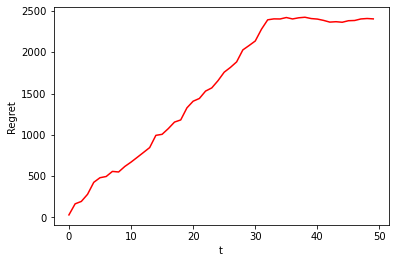

In [12]:
# list of the collected reward
rewards_per_experiment = []
opt = Optimizer.fit_table(all_optimal_subs)[1]
print(opt)

for i in range(0,n_obs):
    num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]
    rewards_per_experiment.append(num_clicks_day_i)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()


